# Exploratory Analysis

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer

from eda import *

In [9]:
df = pd.read_csv('data/news_cleaned.csv')
df.columns = df.columns.str.lower()
df = df.drop(columns=['unnamed: 0', 'snippet_no_climate'])
df.head()

,matchdatetime,station,snippet,tokens
0,2017-01-31 05:53:28,BBCNEWS,beena part to do. the airline industry has not...,"['beena', 'part', 'airline', 'industry', 'part..."
1,2017-01-18 19:21:01,BBCNEWS,"it's beaten it by about 0.1, 0.12 degrees cels...","['beaten', '01', '012', 'degrees', 'celsius', ..."
2,2017-01-05 21:48:46,BBCNEWS,"contact more than expected, how. your co nta c...","['contact', 'expected', 'co', 'nta', 'ct', 'le..."
3,2017-01-05 21:13:33,BBCNEWS,"where every time a marketplace is closed down,...","['every', 'time', 'marketplace', 'closed', 'an..."
4,2017-01-11 03:11:51,BBCNEWS,"applause climate change, a controversial issue...","['applause', 'climate', 'change', 'controversi..."


In [7]:
def remove_bigram_phrases(text, phrases_to_remove):
    for phrase in phrases_to_remove:
        text = text.replace(phrase, '')
    return text

# Climate bi-gram phrases
climate_grams = ["climate change", "global warming", "climate crisis", "greenhouse gas", "greenhouse gases", "carbon tax"]

# Apply the custom function to each row
df['snippet_no_climate'] = df['snippet'].map(lambda x: remove_bigram_phrases(x, climate_grams))

df.head()

,matchdatetime,station,snippet,tokens,snippet_no_climate
0,2017-01-31 05:53:28,BBCNEWS,beena part to do. the airline industry has not...,"['beena', 'part', 'airline', 'industry', 'part...",beena part to do. the airline industry has not...
1,2017-01-18 19:21:01,BBCNEWS,"it's beaten it by about 0.1, 0.12 degrees cels...","['beaten', '01', '012', 'degrees', 'celsius', ...","it's beaten it by about 0.1, 0.12 degrees cels..."
2,2017-01-05 21:48:46,BBCNEWS,"contact more than expected, how. your co nta c...","['contact', 'expected', 'co', 'nta', 'ct', 'le...","contact more than expected, how. your co nta c..."
3,2017-01-05 21:13:33,BBCNEWS,"where every time a marketplace is closed down,...","['every', 'time', 'marketplace', 'closed', 'an...","where every time a marketplace is closed down,..."
4,2017-01-11 03:11:51,BBCNEWS,"applause climate change, a controversial issue...","['applause', 'climate', 'change', 'controversi...","applause , a controversial issue which has see..."


## Bag-Of-Words Feature Extraction

In [31]:
def get_top_n_ngram(corpus: pd.Series, n_phrases: int=20, ngram_min: int=2, ngram_max: int=2, 
                    remove_stopwords: bool=True, remove_climate_phrases: bool=True) -> sns.barplot:
    """
    Finds most common n-gram phrases in a given corpus and plot its distribution.
    :param corpus: pd.Series, text column
    :param n_phrases: int, number of n-gram phrases to return
    :param ngram_min: int, lower n-gram range boundary
    :param ngram_max: int, upper n-gram range boundary
    :param stopwords: bool, toggle stop word removal
    :return: pd.DataFrame of n-grams and their respective counts
    """
    # Check if n-grams should include stop words
    if remove_stopwords:
        stopwords = 'english'
    else:
        stopwords = None

    try: 
        vec = CountVectorizer(ngram_range=(ngram_min, ngram_max), stop_words=stopwords).fit(corpus)

        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0)
        
        words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
        words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)

        # Store word frequencies as pd.DataFrame for plotting
        df = pd.DataFrame(words_freq[:n_phrases], columns=['phrases', 'count'])

        plot_ngram_dist(df, ngram_max, remove_stopwords, remove_climate_phrases)

    except ValueError:
        print("Invalid input")
    
    return df


def plot_ngram_dist(df: pd.DataFrame, ngram_max: int, remove_stopwords: bool, remove_climate_phrases: bool) -> None:
    """ 
    Plot the n-gram distribution.
    :param df: pd.DataFrame, dataframe of climate news snippets.
    :return: sns.histplot
    """
    sns.set_style('darkgrid')
    sns.set_theme(rc={'figure.figsize':(10,4)})

    # Plot bar chart of n-gram frequencies
    sns.barplot(df, x='phrases', y='count', legend=False)
    
    # Title conditions
    if ngram_max == 2:
        ngram = 'Bi'
    elif ngram_max == 3:
        ngram = 'Tri'
    elif ngram_max == 4:
        ngram = 'Four'
    else:
        ngram = 'N'

    if remove_stopwords:
        sw_condition = 'After'  
    else:  
        sw_condition = 'Before'

    if remove_climate_phrases:
        cp_condition = 'And Climate Phrases' 
    else: 
        cp_condition = ''
    
    plt.title(f"{ngram}-Gram Distribution {sw_condition} Removing Stop Words {cp_condition}", fontweight='bold')
    plt.xticks(rotation=60, fontsize=10)
    plt.xlabel("N-Grams")
    plt.ylabel("Count")

    # Save and show plot
    plt.savefig(f'figures/{ngram_max}_gram_dist_{sw_condition}_sw_{cp_condition}_removal.png')
    plt.show()

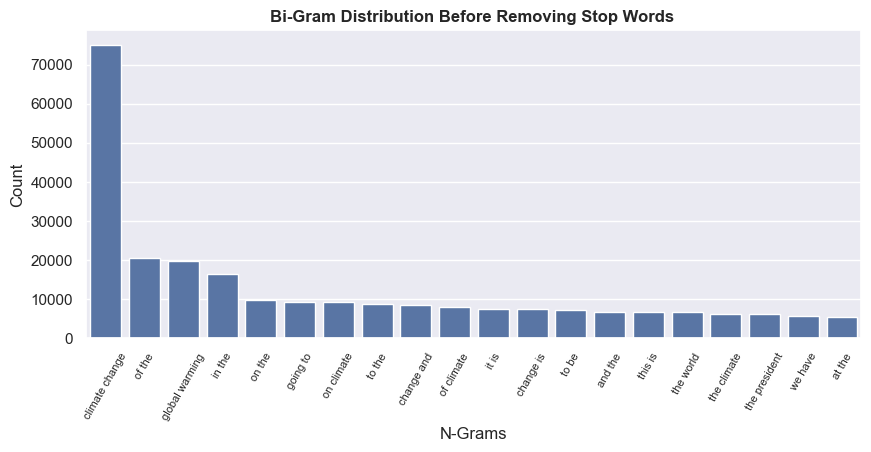

In [16]:
# Bi-gram distribution Before Removing Stopwords (Keep CLimate Phrases)
bi_sw_df = get_top_n_ngram(corpus=df['snippet'], remove_stopwords=False, remove_climate_phrases=False)

In [17]:
bi_sw_df.head()

,phrases,count
0,climate change,75024
1,of the,20464
2,global warming,19862
3,in the,16455
4,on the,9756


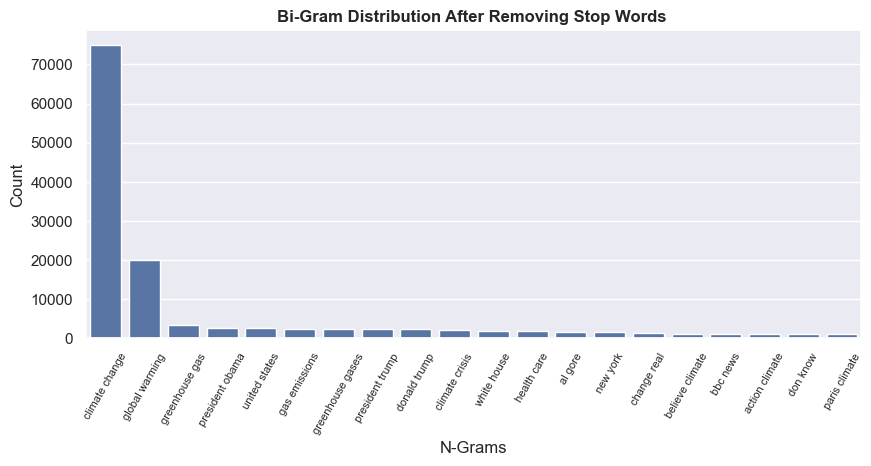

In [18]:
# Bi-gram distribution After Removing Stopwords (Keep CLimate Phrases)
bi_nosw_df = get_top_n_ngram(corpus=df['snippet'], remove_climate_phrases=False)

In [19]:
bi_nosw_df.head()

,phrases,count
0,climate change,75040
1,global warming,19862
2,greenhouse gas,3297
3,president obama,2595
4,united states,2573


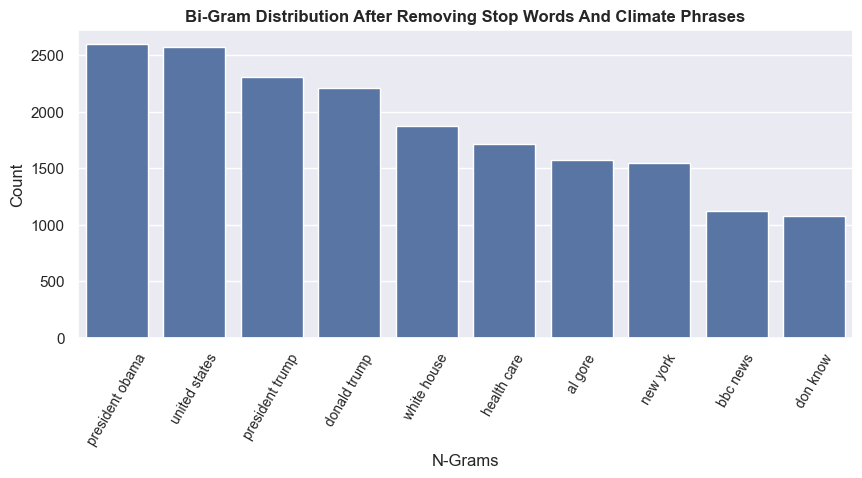

In [32]:
# Bi-gram distribution After Removing CLimate Phrases (Stop Words Removed)
bi_nocp_df = get_top_n_ngram(corpus=df['snippet_no_climate'], n_phrases=10)

In [21]:
bi_nocp_df.head()

,phrases,count
0,president obama,2595
1,united states,2573
2,president trump,2305
3,donald trump,2206
4,white house,1872


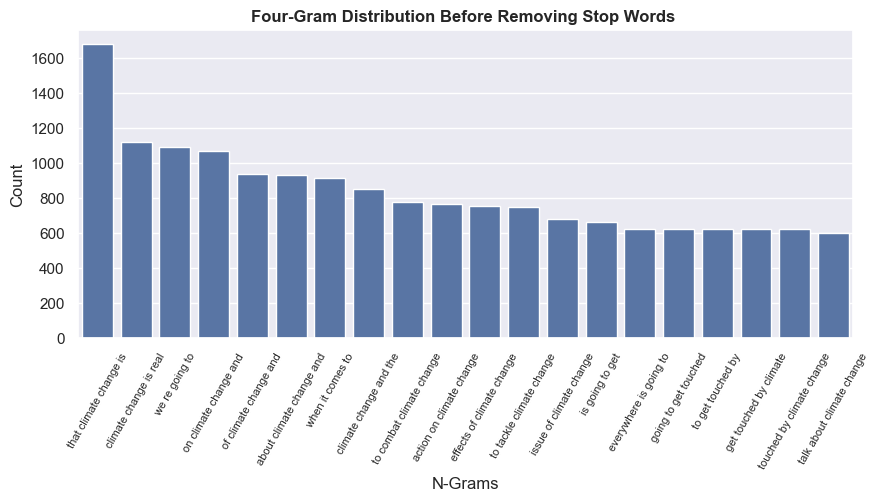

In [22]:
# Four-gram distribution Before Removing CLimate Phrases (Stop Words Removed)
fourgram_sw_df = get_top_n_ngram(corpus=df['snippet'], ngram_min=4, ngram_max=4, 
                                 remove_stopwords=False, remove_climate_phrases=False)

In [23]:
fourgram_sw_df.head()

,phrases,count
0,that climate change is,1679
1,climate change is real,1119
2,we re going to,1093
3,on climate change and,1067
4,of climate change and,939


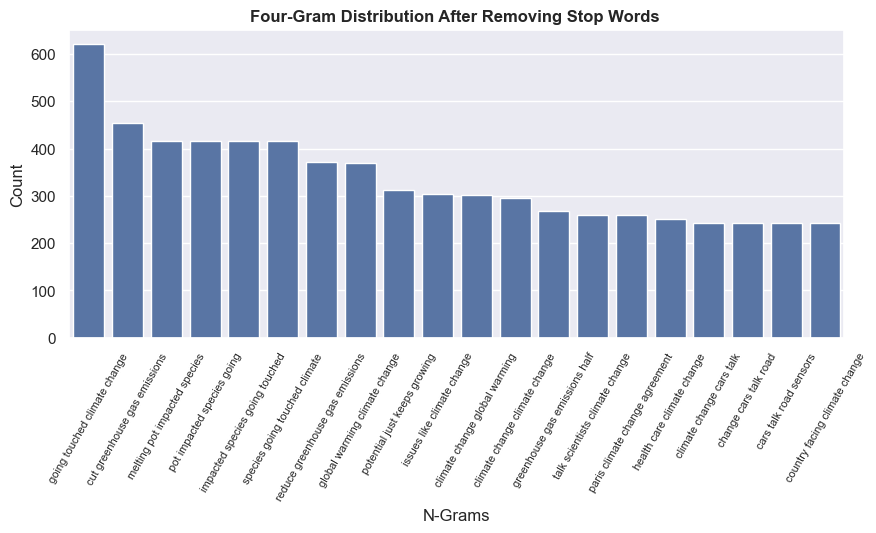

In [24]:
# Four-gram distribution Before Removing CLimate Phrases (Stop Words Removed)
fourgram_nosw_df = get_top_n_ngram(corpus=df['snippet'], ngram_min=4, ngram_max=4,
                remove_climate_phrases=False)

In [25]:
fourgram_nosw_df.head()

,phrases,count
0,going touched climate change,620
1,cut greenhouse gas emissions,454
2,melting pot impacted species,415
3,pot impacted species going,415
4,impacted species going touched,415


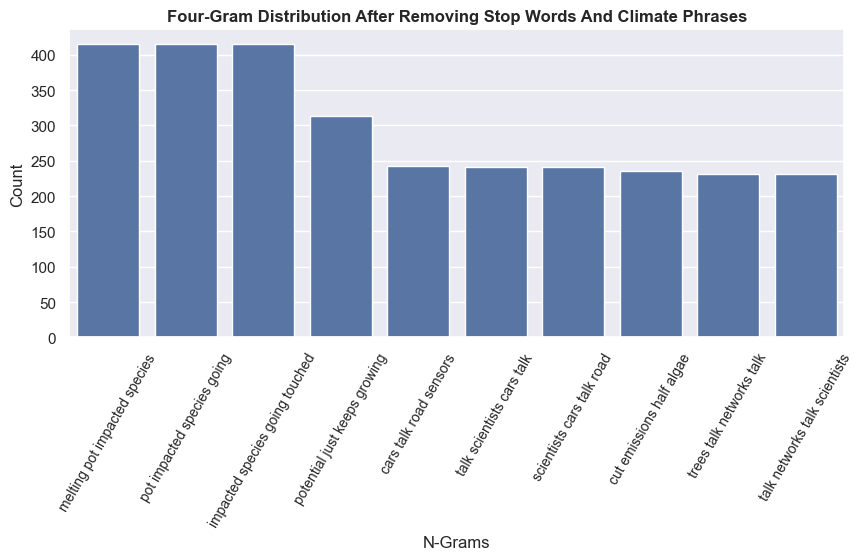

In [33]:
# Four-gram distribution After Removing CLimate Phrases (Stop Words Removed)
fourgram_nocp_df = get_top_n_ngram(corpus=df['snippet_no_climate'], n_phrases=10, ngram_min=4, ngram_max=4)

In [27]:
fourgram_nocp_df.head()

,phrases,count
0,melting pot impacted species,415
1,pot impacted species going,415
2,impacted species going touched,415
3,potential just keeps growing,313
4,cars talk road sensors,242


In [28]:
# bi_sw_df = bi_sw_df.rename(columns={'snippets': 'Bi-Gram w/ Stopwords', 'count': 'Bi-Gram w/ Stopwords Count'})
# bi_nosw_df = bi_nosw_df.rename(columns={'snippets': 'Bi-Gram w/o Stopwords', 'count': 'Bi-Gram w/o Stopwords Count'})

# bi_gram_df = pd.concat([bi_sw_df, 
#                        bi_nosw_df],
#                        ignore_index=False)
# bi_gram_df.head()

## TF-IDF